In [1]:
from time import time
from pprint import pprint
from collections import defaultdict


from IPython import display
from matplotlib import cm
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.cluster import KMeans
from scipy.stats import describe, kurtosis
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.random_projection import SparseRandomProjection, johnson_lindenstrauss_min_dim

In [2]:
data = pd.read_csv("../data/heart.csv")

In [3]:
X = data.loc[:, data.columns != 'target']
y = data.loc[:, data.columns == 'target'].values.ravel()

In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Clustering

## K-Means

In [5]:
n_clusters = np.hstack(np.arange(2, 13)).astype(np.int)

In [6]:
km_res = defaultdict(dict)
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0)
    t0 = time()
    km.fit(X)
    t = time() - t0
    y_km = km.predict(X)
    km_res[k]['dist'] = km.inertia_
    km_res[k]['time'] = t
    km_res[k]['sil'] = silhouette_score(X, y_km, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, t))

done k=2 in 0.019 sec
done k=3 in 0.020 sec
done k=4 in 0.024 sec
done k=5 in 0.025 sec
done k=6 in 0.033 sec
done k=7 in 0.036 sec
done k=8 in 0.034 sec
done k=9 in 0.040 sec
done k=10 in 0.046 sec
done k=11 in 0.049 sec
done k=12 in 0.051 sec


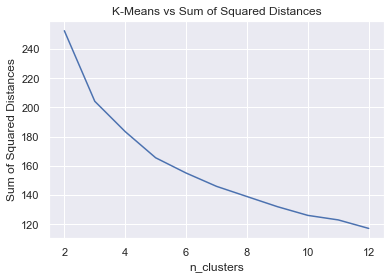

In [7]:
plt.plot(n_clusters, [km_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Sum of Squared Distances')
plt.title("K-Means vs Sum of Squared Distances")
plt.show()

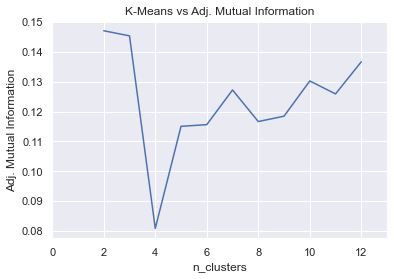

In [8]:
plt.plot(n_clusters, [km_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.title("K-Means vs Adj. Mutual Information")
plt.xlim([0, 13])
plt.show()

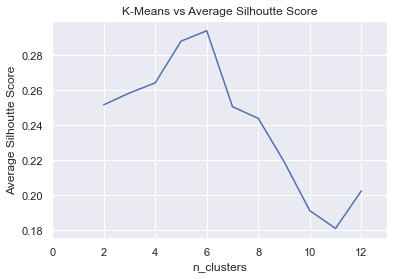

In [9]:
plt.plot(n_clusters, [km_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average Silhoutte Score')
plt.title("K-Means vs Average Silhoutte Score")
plt.xlim([0, 13])
plt.show()

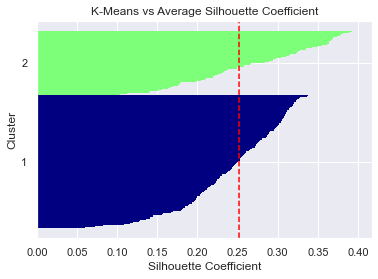

In [10]:
km = KMeans(n_clusters=2,
                random_state=0)
y_km = km.fit_predict(X)
cluster_labels = np.unique(y_km)
m_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / m_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.title("K-Means vs Average Silhouette Coefficient")
plt.show()

## Expectation Maximization

In [11]:
em_res = defaultdict(dict)
for k in n_clusters:
    gm = GaussianMixture(
        n_components=k,
        random_state=0,
#         n_jobs=-1, # Not supported for GMM?
        n_init=1,
        init_params='kmeans',
#         max_iter=600,
    )
    t0 = time()
    gm.fit(X)
    t = time() - t0
    y_gm = gm.predict(X)
    em_res[k]['bic'] = gm.bic(X)
    em_res[k]['aic'] = gm.aic(X)
    em_res[k]['ll'] = gm.score(X)
    em_res[k]['time'] = t
    em_res[k]['sil'] = silhouette_score(X, y_gm, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        em_res[k]['ami'] = ami(y, y_gm)
    print('done k=%i in %.3f sec' % (k, t))

done k=2 in 0.005 sec
done k=3 in 0.008 sec
done k=4 in 0.012 sec
done k=5 in 0.009 sec
done k=6 in 0.009 sec
done k=7 in 0.014 sec
done k=8 in 0.021 sec
done k=9 in 0.021 sec
done k=10 in 0.027 sec
done k=11 in 0.030 sec
done k=12 in 0.031 sec


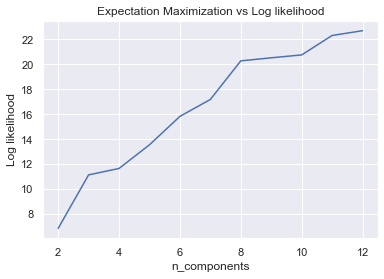

In [12]:
plt.plot(n_clusters, [em_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.title("Expectation Maximization vs Log likelihood")
plt.show()

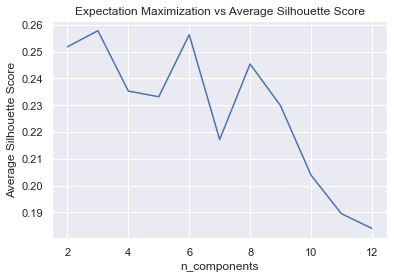

In [13]:
plt.plot(n_clusters, [em_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average Silhouette Score')
plt.title("Expectation Maximization vs Average Silhouette Score")
plt.show()

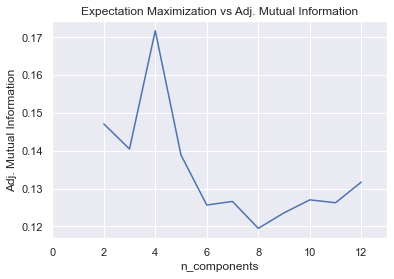

In [14]:
plt.plot(n_clusters, [em_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Adj. Mutual Information')
plt.title("Expectation Maximization vs Adj. Mutual Information")
plt.xlim([0, 13])
plt.show()

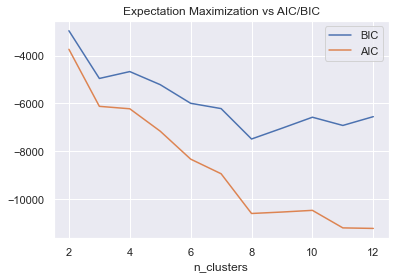

In [15]:
plt.plot(n_clusters, [em_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.title("Expectation Maximization vs AIC/BIC")
plt.show()

# Dimensionality Reduction

## PCA

In [16]:
pca = PCA(n_components=None, random_state=0)
pca.fit(X)

PCA(random_state=0)

In [17]:
normed = pca.components_[1] / np.linalg.norm(pca.components_[1])
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.25]

Index(['sex', 'exang'], dtype='object')

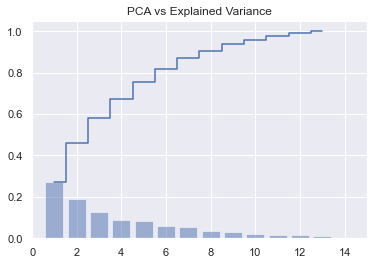

In [18]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 15])
plt.title("PCA vs Explained Variance")
plt.show()

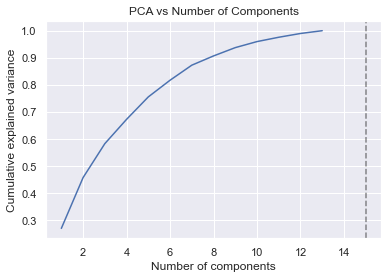

In [19]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.title("PCA vs Number of Components")
plt.axvline(15, linestyle='--', color='k', alpha=0.5)

## ICA

In [20]:
ica = FastICA(
    n_components=10,
    random_state=0,
    max_iter=400,
)
X_tr = ica.fit_transform(X)
kurt_df = pd.DataFrame(kurtosis(X_tr, axis=0), columns=['kurtosis'])
kurt_df.sort_values(by='kurtosis', ascending=False)

,kurtosis
3,2.673149
9,2.671643
1,1.949622
8,1.255322
7,-0.682419
6,-0.850042
0,-1.017687
2,-1.163392
4,-1.338123
5,-1.466571


Kurtosis: higher values indicate the presence of tail extremity, i.e. more data outside of the peak. It's a measure of non-gaussianity and is the basis of ICA.

In [21]:
component_counts = np.hstack((np.arange(1, 13),)).astype(np.int)
total_kurtosis = {}

for component_count in component_counts:
    tmp_ica = FastICA(
        random_state=0,
        n_components=component_count,
    )
    tmp_X_tr = tmp_ica.fit_transform(X)
    total_kurtosis[component_count] = np.abs(kurtosis(tmp_X_tr, axis=0)).sum()

pprint(total_kurtosis)

{1: 1.0204617976402475,
 2: 2.586578363489874,
 3: 4.007513965054976,
 4: 4.719450186745294,
 5: 5.687094747020889,
 6: 7.0645654436851535,
 7: 8.169244483086409,
 8: 10.80357430811965,
 9: 12.953317321965757,
 10: 15.06797045499933,
 11: 18.152458397560416,
 12: 18.950311966857278}


/Users/cdang/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/cdang/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [22]:
res = sum(total_kurtosis.values()) / len(total_kurtosis)
res

9.098545119685438

Text(0.5, 1.0, 'ICA vs Number of Components')

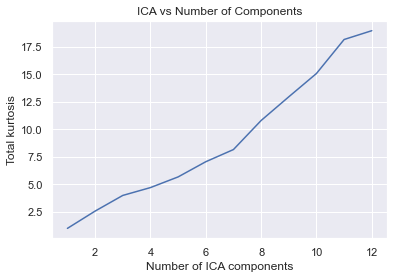

In [23]:
pd.Series(total_kurtosis).plot()
plt.ylabel('Total kurtosis')
plt.xlabel('Number of ICA components')
plt.title("ICA vs Number of Components")

In [24]:
ica10 = FastICA(
    random_state=0,
    n_components=10,
)
X_tr10 = ica10.fit_transform(X)
kurt_df10 = pd.DataFrame(kurtosis(X_tr10, axis=0), columns=['kurtosis'])
kurt_df10.sort_values(by='kurtosis', ascending=False)

,kurtosis
3,2.673149
9,2.671643
1,1.949622
8,1.255322
7,-0.682419
6,-0.850042
0,-1.017687
2,-1.163392
4,-1.338123
5,-1.466571


In [25]:
normed = ica10.components_[6] / np.linalg.norm(ica10.components_[6])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['trestbps', 'thalach', 'exang', 'slope', 'thal'], dtype='object')

In [26]:
normed = ica10.components_[1] / np.linalg.norm(ica10.components_[1])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['trestbps', 'fbs', 'oldpeak', 'ca', 'thal'], dtype='object')

## Randomized Projections

In [27]:
rp = SparseRandomProjection(n_components=5)
rp.fit(X)

SparseRandomProjection(n_components=5)

In [28]:
eps = np.linspace(0, 1.0, 10)
n_samples = X.shape[0]
n_component_bounds = johnson_lindenstrauss_min_dim(n_samples)

In [29]:
component_counts = np.array([1, 2, 10, 20, 30, 50, 75, 100]).astype(np.int)

In [30]:
rp = SparseRandomProjection(
        random_state=0,
        n_components=1,
        eps=None
    )
rp.fit(X)
rp_components = rp.components_
rp_components.shape
# for _ in range(10):
#     rp = SparseRandomProjection(
#         random_state=0,
#         n_components=50,
#         eps=None
#     )
    
#     np.hstack()

(1, 13)

## LDA

In [31]:
lda = LDA(
    n_components=None,
)
X_tr = lda.fit_transform(X, y)
X_tr.shape

(303, 1)

In [32]:
describe(X_tr)

DescribeResult(nobs=303, minmax=(array([-3.56571974]), array([2.92552286])), mean=array([0.]), variance=array([2.06589008]), skewness=array([-0.37841593]), kurtosis=array([-0.7413686]))

Text(0.5, 0, 'Number of components')

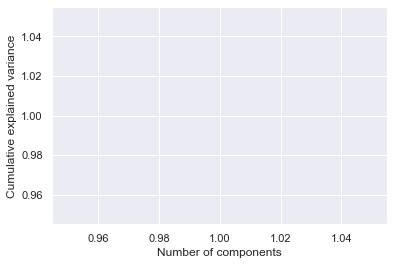

In [33]:
n_lda_components = lda.explained_variance_ratio_.shape[0]
plt.plot(range(1, n_lda_components + 1), np.cumsum(lda.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
# plt.axvline(29, linestyle='--', color='k', alpha=0.5)

# Dimensionality Reduction + Clustering

## PCA

In [34]:
component_counts = [1,2,3,4,5,6,7,8,9,10,11,12,13]
pca_km_results = {}

for cc in component_counts:
    tmp_pca = PCA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_pca.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    pca_km_results[cc] = tmp_res
    


Doing 1 components
done k=2 in 0.021 sec
done k=3 in 0.021 sec
done k=4 in 0.026 sec
done k=5 in 0.030 sec
done k=6 in 0.027 sec
done k=7 in 0.026 sec
done k=8 in 0.032 sec
done k=9 in 0.034 sec
done k=10 in 0.032 sec
done k=11 in 0.036 sec
done k=12 in 0.039 sec
Doing 2 components
done k=2 in 0.015 sec
done k=3 in 0.015 sec
done k=4 in 0.022 sec
done k=5 in 0.025 sec
done k=6 in 0.029 sec
done k=7 in 0.031 sec
done k=8 in 0.035 sec
done k=9 in 0.039 sec
done k=10 in 0.040 sec
done k=11 in 0.041 sec
done k=12 in 0.041 sec
Doing 3 components
done k=2 in 0.011 sec
done k=3 in 0.017 sec
done k=4 in 0.017 sec
done k=5 in 0.020 sec
done k=6 in 0.023 sec
done k=7 in 0.027 sec
done k=8 in 0.032 sec
done k=9 in 0.037 sec
done k=10 in 0.041 sec
done k=11 in 0.045 sec
done k=12 in 0.050 sec
Doing 4 components
done k=2 in 0.013 sec
done k=3 in 0.016 sec
done k=4 in 0.020 sec
done k=5 in 0.023 sec
done k=6 in 0.027 sec
done k=7 in 0.031 sec
done k=8 in 0.031 sec
done k=9 in 0.034 sec
done k=10 in 

In [35]:
test_pca = PCA(n_components=2)
x_tr_test = test_pca.fit_transform(X)
test_cluster = KMeans(n_clusters=2)
clusters_test = test_cluster.fit_predict(x_tr_test)

In [36]:
print(x_tr_test.shape, clusters_test.shape)
print(np.hstack((x_tr_test, clusters_test[:, None])))

(303, 2) (303,)
[[-0.17834298 -0.45832503  1.        ]
 [-0.13475302 -0.38519153  1.        ]
 [-0.66005491  0.43004559  1.        ]
 [-0.28046062 -0.43895558  1.        ]
 [ 0.18436682  0.88557971  0.        ]
 [-0.06422955 -0.26736326  1.        ]
 [-0.51068046  0.55204699  1.        ]
 [-0.26416234 -0.47274051  1.        ]
 [-0.29974867 -0.58438589  1.        ]
 [-0.366003   -0.49904164  1.        ]
 [-0.13302123 -0.34839726  1.        ]
 [-0.79102907  0.39606197  1.        ]
 [-0.28203193 -0.44048639  1.        ]
 [ 0.45698299 -0.14377936  0.        ]
 [-0.82986916  0.26399646  1.        ]
 [-0.66766167  0.45535826  1.        ]
 [-0.82510224  0.39563656  1.        ]
 [-0.5747564   0.52837485  1.        ]
 [-0.14757321 -0.36777716  1.        ]
 [-0.79739126  0.35721461  1.        ]
 [ 0.00707271 -0.2941744   1.        ]
 [ 0.33845408 -0.19693166  0.        ]
 [-0.19401113 -0.39327311  1.        ]
 [ 0.57181099 -0.13198633  0.        ]
 [ 0.28673313 -0.28115951  0.        ]
 [-0.6057

In [37]:
pca_gm_results = {}
# component_counts = [5, 10, 13]

for cc in component_counts:
    tmp_pca = PCA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_pca.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    pca_gm_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.008 sec
done k=3 in 0.008 sec
done k=4 in 0.006 sec
done k=5 in 0.006 sec
done k=6 in 0.007 sec
done k=7 in 0.007 sec
done k=8 in 0.008 sec
done k=9 in 0.009 sec
done k=10 in 0.011 sec
done k=11 in 0.010 sec
done k=12 in 0.011 sec
Doing 2 components
done k=2 in 0.004 sec
done k=3 in 0.004 sec
done k=4 in 0.009 sec
done k=5 in 0.006 sec
done k=6 in 0.020 sec
done k=7 in 0.021 sec
done k=8 in 0.015 sec
done k=9 in 0.032 sec
done k=10 in 0.032 sec
done k=11 in 0.033 sec
done k=12 in 0.048 sec
Doing 3 components
done k=2 in 0.004 sec
done k=3 in 0.009 sec
done k=4 in 0.010 sec
done k=5 in 0.011 sec
done k=6 in 0.012 sec
done k=7 in 0.011 sec
done k=8 in 0.014 sec
done k=9 in 0.028 sec
done k=10 in 0.029 sec
done k=11 in 0.033 sec
done k=12 in 0.034 sec
Doing 4 components
done k=2 in 0.004 sec
done k=3 in 0.006 sec
done k=4 in 0.009 sec
done k=5 in 0.013 sec
done k=6 in 0.009 sec
done k=7 in 0.010 sec
done k=8 in 0.008 sec
done k=9 in 0.008 sec
done k=10 in 

In [38]:
# component_counts = [5, 10, 13]
# pca_km_results = {cc: load_cluster_result(dataset, 'km', 'pca%i' % cc) for cc in component_counts}
# pca_gm_results = {cc: load_cluster_result(dataset, 'em', 'pca%i' % cc) for cc in component_counts}

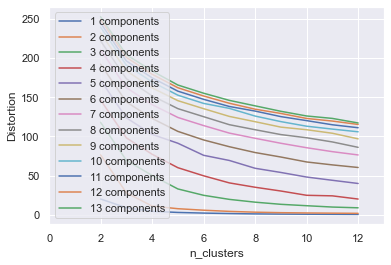

In [39]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.xlim([0,13])
plt.show()

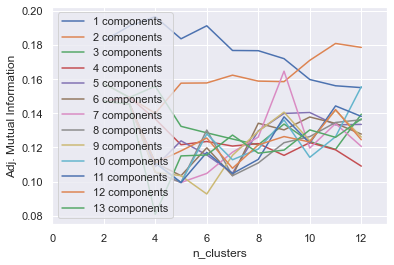

In [40]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 13])
plt.legend(loc='best')
plt.show()

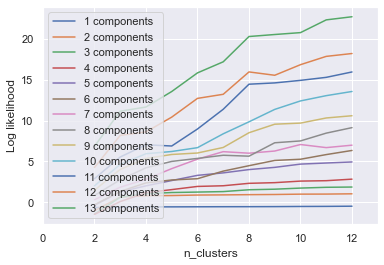

In [41]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.xlim([0, 13])
plt.legend(loc='best')
plt.show()

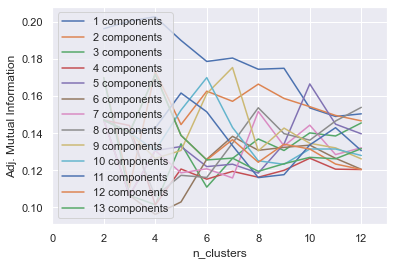

In [42]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.xlim([0,13])
plt.show()

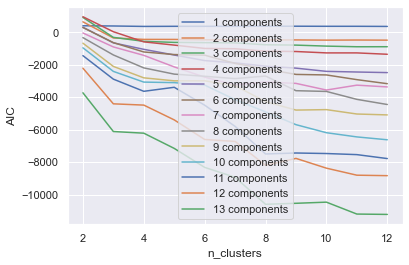

In [43]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

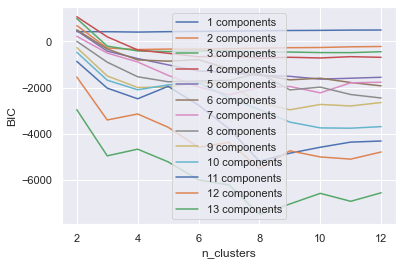

In [44]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## ICA

In [45]:
component_counts = [1,2,3,4,5,6,7,8,9,10,11,12,13]
# component_counts = [1, 2, 10, 20, 30, 60, 70, 80]
ica_km_results = {}

for cc in component_counts:
    tmp_dr = FastICA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    ica_km_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.073 sec
done k=3 in 0.022 sec
done k=4 in 0.022 sec
done k=5 in 0.029 sec
done k=6 in 0.026 sec
done k=7 in 0.025 sec
done k=8 in 0.030 sec
done k=9 in 0.034 sec
done k=10 in 0.032 sec
done k=11 in 0.036 sec
done k=12 in 0.041 sec
Doing 2 components
done k=2 in 0.014 sec
done k=3 in 0.016 sec
done k=4 in 0.019 sec
done k=5 in 0.028 sec
done k=6 in 0.032 sec
done k=7 in 0.031 sec
done k=8 in 0.034 sec
done k=9 in 0.034 sec
done k=10 in 0.037 sec
done k=11 in 0.039 sec
done k=12 in 0.042 sec
Doing 3 components
done k=2 in 0.013 sec
done k=3 in 0.015 sec
done k=4 in 0.017 sec
done k=5 in 0.021 sec
done k=6 in 0.024 sec
done k=7 in 0.030 sec
done k=8 in 0.036 sec
done k=9 in 0.041 sec
done k=10 in 0.043 sec
done k=11 in 0.047 sec
done k=12 in 0.044 sec
Doing 4 components
done k=2 in 0.014 sec
done k=3 in 0.016 sec
done k=4 in 0.019 sec
done k=5 in 0.021 sec
done k=6 in 0.023 sec
done k=7 in 0.028 sec
done k=8 in 0.033 sec
done k=9 in 0.037 sec
done k=10 in 

/Users/cdang/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


done k=3 in 0.039 sec
done k=4 in 0.039 sec
done k=5 in 0.040 sec
done k=6 in 0.042 sec
done k=7 in 0.048 sec
done k=8 in 0.049 sec
done k=9 in 0.059 sec
done k=10 in 0.048 sec
done k=11 in 0.055 sec
done k=12 in 0.057 sec
Doing 12 components
done k=2 in 0.033 sec
done k=3 in 0.032 sec
done k=4 in 0.042 sec


/Users/cdang/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


done k=5 in 0.038 sec
done k=6 in 0.041 sec
done k=7 in 0.040 sec
done k=8 in 0.048 sec
done k=9 in 0.045 sec
done k=10 in 0.062 sec
done k=11 in 0.051 sec
done k=12 in 0.051 sec
Doing 13 components
done k=2 in 0.029 sec
done k=3 in 0.032 sec
done k=4 in 0.043 sec
done k=5 in 0.039 sec
done k=6 in 0.048 sec
done k=7 in 0.053 sec
done k=8 in 0.050 sec
done k=9 in 0.050 sec
done k=10 in 0.048 sec
done k=11 in 0.056 sec
done k=12 in 0.058 sec


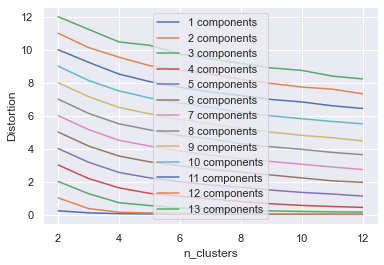

In [46]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

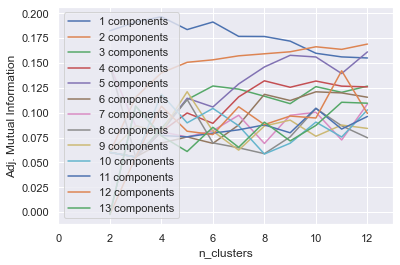

In [47]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 13])
plt.legend(loc='best')
plt.show()

In [48]:
ica_gm_results = {}

for cc in component_counts:
    tmp_dr = FastICA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    ica_gm_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.007 sec
done k=3 in 0.009 sec
done k=4 in 0.007 sec
done k=5 in 0.007 sec
done k=6 in 0.008 sec
done k=7 in 0.008 sec
done k=8 in 0.008 sec
done k=9 in 0.008 sec
done k=10 in 0.015 sec
done k=11 in 0.011 sec
done k=12 in 0.011 sec
Doing 2 components
done k=2 in 0.004 sec
done k=3 in 0.005 sec
done k=4 in 0.006 sec
done k=5 in 0.006 sec
done k=6 in 0.011 sec
done k=7 in 0.017 sec
done k=8 in 0.022 sec
done k=9 in 0.019 sec
done k=10 in 0.020 sec
done k=11 in 0.051 sec
done k=12 in 0.060 sec
Doing 3 components
done k=2 in 0.004 sec
done k=3 in 0.005 sec
done k=4 in 0.007 sec
done k=5 in 0.007 sec
done k=6 in 0.013 sec
done k=7 in 0.013 sec
done k=8 in 0.016 sec
done k=9 in 0.018 sec
done k=10 in 0.024 sec
done k=11 in 0.022 sec
done k=12 in 0.027 sec
Doing 4 components
done k=2 in 0.004 sec
done k=3 in 0.007 sec
done k=4 in 0.016 sec
done k=5 in 0.019 sec
done k=6 in 0.010 sec
done k=7 in 0.011 sec
done k=8 in 0.011 sec
done k=9 in 0.019 sec
done k=10 in 

/Users/cdang/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Doing 11 components
done k=2 in 0.005 sec
done k=3 in 0.006 sec
done k=4 in 0.012 sec
done k=5 in 0.015 sec
done k=6 in 0.017 sec
done k=7 in 0.025 sec
done k=8 in 0.020 sec
done k=9 in 0.026 sec
done k=10 in 0.041 sec
done k=11 in 0.031 sec
done k=12 in 0.063 sec


/Users/cdang/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Doing 12 components
done k=2 in 0.006 sec
done k=3 in 0.008 sec
done k=4 in 0.021 sec
done k=5 in 0.028 sec
done k=6 in 0.023 sec
done k=7 in 0.029 sec
done k=8 in 0.042 sec
done k=9 in 0.020 sec
done k=10 in 0.034 sec
done k=11 in 0.029 sec
done k=12 in 0.037 sec
Doing 13 components
done k=2 in 0.006 sec
done k=3 in 0.008 sec
done k=4 in 0.011 sec
done k=5 in 0.015 sec
done k=6 in 0.023 sec
done k=7 in 0.022 sec
done k=8 in 0.046 sec
done k=9 in 0.030 sec
done k=10 in 0.044 sec
done k=11 in 0.035 sec
done k=12 in 0.036 sec


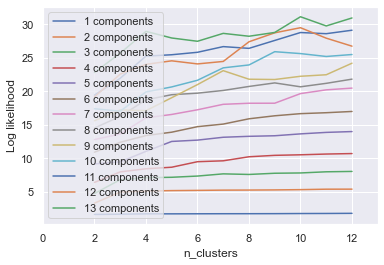

In [49]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.xlim([0, 13])
plt.legend(loc='best')
plt.show()

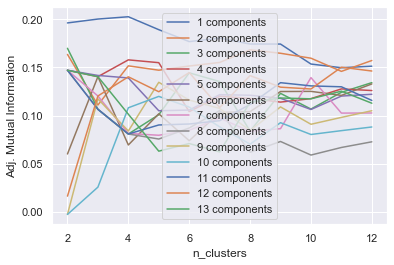

In [50]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

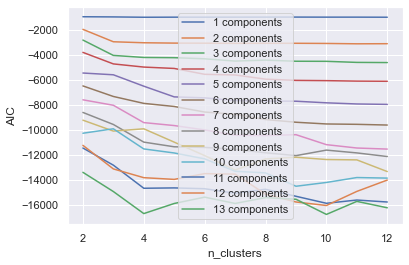

In [51]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

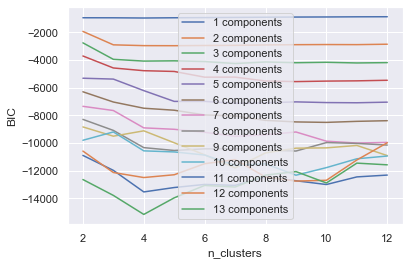

In [52]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## RP

In [53]:
component_counts = [1,2,3,4,5,6,7,8,9,10,11,12,13]
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
rp_km_results = {}

for cc in component_counts:
    tmp_dr = SparseRandomProjection(n_components=cc, random_state=0, eps=None)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    rp_km_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.017 sec
done k=3 in 0.022 sec
done k=4 in 0.021 sec
done k=5 in 0.026 sec
done k=6 in 0.029 sec
done k=7 in 0.032 sec
done k=8 in 0.035 sec
done k=9 in 0.042 sec
done k=10 in 0.042 sec
done k=12 in 0.039 sec
done k=14 in 0.045 sec
done k=16 in 0.053 sec
done k=18 in 0.054 sec
done k=20 in 0.059 sec
done k=30 in 0.079 sec
done k=40 in 0.102 sec
done k=50 in 0.125 sec
done k=60 in 0.191 sec
done k=80 in 0.247 sec
Doing 2 components
done k=2 in 0.019 sec
done k=3 in 0.047 sec
done k=4 in 0.042 sec
done k=5 in 0.050 sec
done k=6 in 0.061 sec
done k=7 in 0.046 sec
done k=8 in 0.044 sec
done k=9 in 0.056 sec
done k=10 in 0.054 sec
done k=12 in 0.062 sec
done k=14 in 0.070 sec
done k=16 in 0.071 sec
done k=18 in 0.066 sec
done k=20 in 0.061 sec
done k=30 in 0.089 sec
done k=40 in 0.128 sec
done k=50 in 0.160 sec
done k=60 in 0.149 sec
done k=80 in 0.199 sec
Doing 3 components
done k=2 in 0.012 sec
done k=3 in 0.022 sec
done k=4 in 0.023 sec
done k=5 in 0.030 s

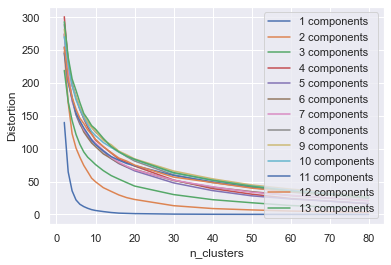

In [54]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

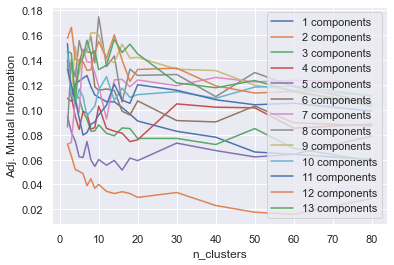

In [55]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

In [56]:
rp_gm_results = {}

for cc in component_counts:
    tmp_dr = SparseRandomProjection(n_components=cc, random_state=0, eps=None)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    rp_gm_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.008 sec
done k=3 in 0.013 sec
done k=4 in 0.017 sec
done k=5 in 0.012 sec
done k=6 in 0.009 sec
done k=7 in 0.012 sec
done k=8 in 0.016 sec
done k=9 in 0.018 sec
done k=10 in 0.023 sec
done k=12 in 0.020 sec
done k=14 in 0.045 sec
done k=16 in 0.030 sec
done k=18 in 0.029 sec
done k=20 in 0.028 sec
done k=30 in 0.040 sec
done k=40 in 0.060 sec
done k=50 in 0.112 sec
done k=60 in 0.071 sec
done k=80 in 0.142 sec
Doing 2 components
done k=2 in 0.008 sec
done k=3 in 0.017 sec
done k=4 in 0.025 sec
done k=5 in 0.017 sec
done k=6 in 0.017 sec
done k=7 in 0.031 sec
done k=8 in 0.046 sec
done k=9 in 0.052 sec
done k=10 in 0.069 sec
done k=12 in 0.056 sec
done k=14 in 0.059 sec
done k=16 in 0.107 sec
done k=18 in 0.088 sec
done k=20 in 0.086 sec
done k=30 in 0.163 sec
done k=40 in 0.161 sec
done k=50 in 0.208 sec
done k=60 in 0.271 sec
done k=80 in 0.303 sec
Doing 3 components
done k=2 in 0.006 sec
done k=3 in 0.028 sec
done k=4 in 0.021 sec
done k=5 in 0.031 s

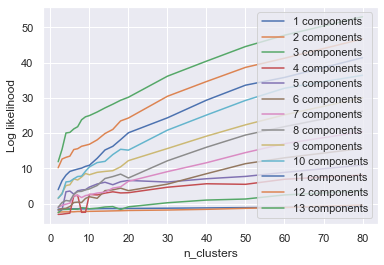

In [57]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
# plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

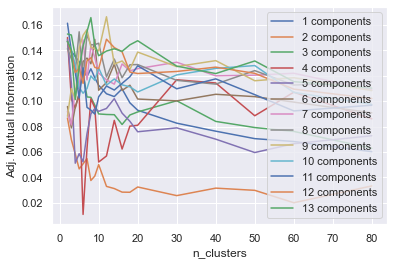

In [58]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

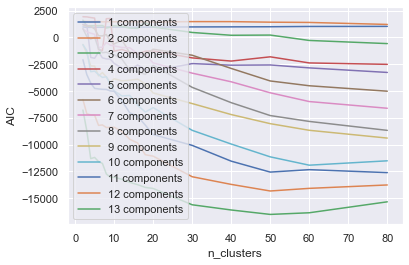

In [59]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='lower left')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

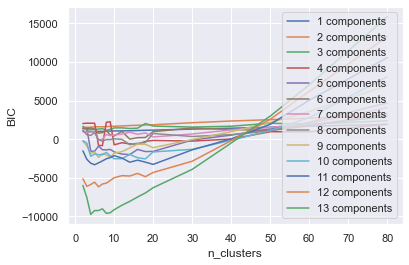

In [60]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## LDA

In [61]:
component_counts = [1]
component_counts = [1]
lda_km_results = {}

for cc in component_counts:
    tmp_dr = LDA(n_components=None)
    tmp_X_tr = tmp_dr.fit_transform(X, y)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    lda_km_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.019 sec
done k=3 in 0.029 sec
done k=4 in 0.038 sec
done k=5 in 0.038 sec
done k=6 in 0.048 sec
done k=7 in 0.050 sec
done k=8 in 0.047 sec
done k=9 in 0.050 sec
done k=10 in 0.050 sec
done k=12 in 0.058 sec
done k=14 in 0.062 sec
done k=16 in 0.075 sec
done k=18 in 0.080 sec
done k=20 in 0.079 sec
done k=30 in 0.115 sec
done k=40 in 0.148 sec
done k=50 in 0.191 sec
done k=60 in 0.217 sec
done k=80 in 0.288 sec


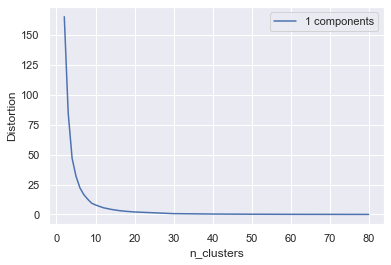

In [62]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

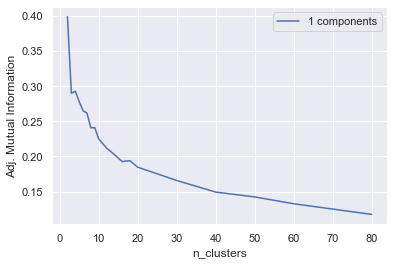

In [63]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

In [64]:
lda_gm_results = {}

for cc in component_counts:
    tmp_dr = LDA(n_components=None)
    tmp_X_tr = tmp_dr.fit_transform(X, y)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    lda_gm_results[cc] = tmp_res

Doing 1 components
done k=2 in 0.005 sec
done k=3 in 0.007 sec
done k=4 in 0.011 sec
done k=5 in 0.009 sec
done k=6 in 0.010 sec
done k=7 in 0.012 sec
done k=8 in 0.012 sec
done k=9 in 0.015 sec
done k=10 in 0.013 sec
done k=12 in 0.015 sec
done k=14 in 0.020 sec
done k=16 in 0.023 sec
done k=18 in 0.024 sec
done k=20 in 0.030 sec
done k=30 in 0.040 sec
done k=40 in 0.051 sec
done k=50 in 0.084 sec
done k=60 in 0.075 sec
done k=80 in 0.089 sec


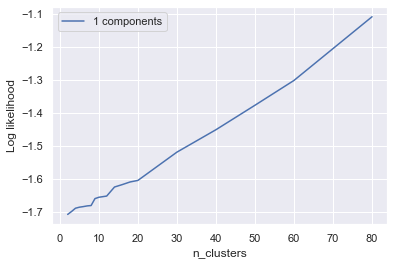

In [65]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.legend(loc='best')
plt.show()

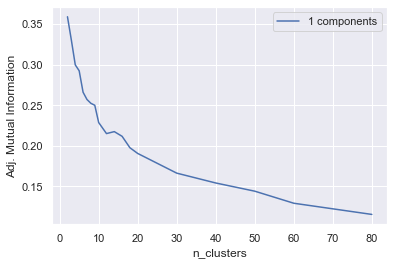

In [66]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

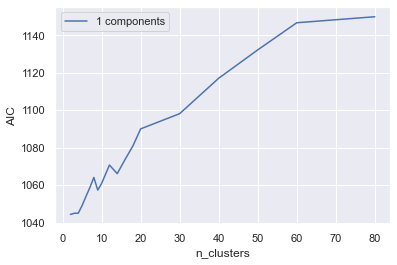

In [67]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

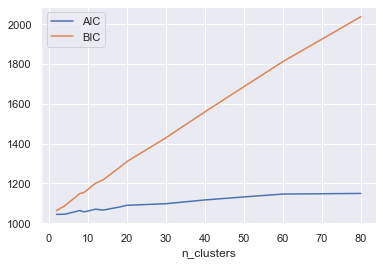

In [68]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['aic'] for k in n_clusters], label='AIC')
    plt.plot(n_clusters, [lda_gm_results[cc][k]['bic'] for k in n_clusters], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()